In [1]:
import os
import uproot as ur
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
paths = []

for (path, dirnames, filenames) in os.walk('/home/dmisra/eic/segmentation_testing'):
    paths.extend(os.path.join(path, name) for name in filenames)

In [3]:
samples = {}

for path in paths:
    with ur.open(path) as file:
       tree = file["events"]
       samples[os.path.basename(f'{path}')] = tree.arrays()

In [4]:
#Crossing angle
CrossingAngle = -0.025

#Get layerID from cellID
def bitExtract(n, k, p):  
    return (((1 << k) - 1)  &  (n >> (p-1)))

#RMS90
def is_outlier(df):
    p_05 = df.quantile(.05)
    p_95 = df.quantile(.95)
    return ~df.between(p_05, p_95)

Components = ['ZDCEcalHits', 'ZDC_WSi_Hits', 'ZDC_PbSi_Hits', 'ZDCHcalHits']

In [5]:
def spread(data, branch, axis, n): 

    spread = pd.DataFrame()
    labels = pd.DataFrame()

    for i in range(n):
        index = str(i)

        x_0 = np.array(data[f"{branch}.position.x"][i])
        y_0 = np.array(data[f"{branch}.position.y"][i])
        z_0 = np.array(data[f"{branch}.position.z"][i])
    
        axis_dict = {'x':x_0 * np.cos(CrossingAngle) - z_0 * np.sin(CrossingAngle), 'y':y_0}

        PIDlabel = data["MCParticles.PDG"][0,0] == 11
        energylabel = np.sqrt(data["MCParticles.momentum.x"][0,0]**2 + data["MCParticles.momentum.y"][0,0]**2 + data["MCParticles.momentum.z"][0,0]**2)
        
        labels_df = pd.DataFrame([PIDlabel, energylabel]).T
        labels_df.columns = ['PID', 'Energy']

        cellID = np.array(data[f"{branch}.cellID"][i])
        layerID = bitExtract(cellID, 6, 9)

        df = pd.DataFrame({f'{index}': axis_dict[axis], 'layerID': layerID})
        layers = df.groupby("layerID")[f'{index}']
        df_rms = df[{'layerID',f'{index}'}][~layers.apply(is_outlier)]
        
        if len(df_rms) != 0:
            spread = pd.concat([spread, df_rms.groupby("layerID").std()], axis=1)
        
        labels = pd.concat([labels, labels_df])

    return spread.T, labels

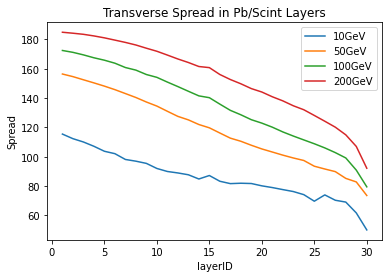

In [6]:
spread(samples['zdc_neutron_10GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_50GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_100GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_200GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
plt.legend(["10GeV", "50GeV", "100GeV", "200GeV"])
plt.xlabel("layerID")
plt.ylabel("Spread")
plt.title("Transverse Spread in Pb/Scint Layers")
plt.savefig("hcalspread.pdf")

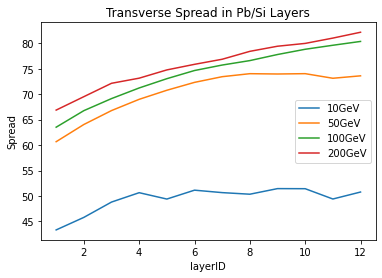

In [7]:
spread(samples['zdc_neutron_10GeV_10e4.edm4hep.root'], "ZDC_PbSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_50GeV_10e4.edm4hep.root'], "ZDC_PbSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_100GeV_10e4.edm4hep.root'], "ZDC_PbSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_200GeV_10e4.edm4hep.root'], "ZDC_PbSi_Hits", "x", 10000)[0].mean().plot()
plt.legend(["10GeV", "50GeV", "100GeV", "200GeV"])
plt.xlabel("layerID")
plt.ylabel("Spread")
plt.title("Transverse Spread in Pb/Si Layers")
plt.savefig("hcalspread.pdf")

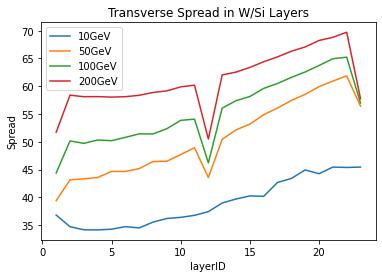

In [8]:
spread(samples['zdc_neutron_10GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_50GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_100GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_200GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
plt.legend(["10GeV", "50GeV", "100GeV", "200GeV"])
plt.xlabel("layerID")
plt.ylabel("Spread")
plt.title("Transverse Spread in W/Si Layers")
plt.savefig("WSispread.pdf")

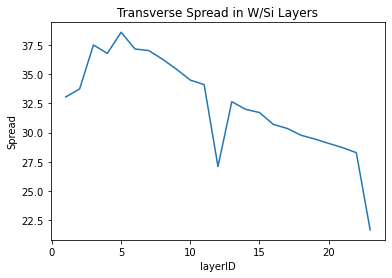

In [7]:
spread(samples['out_neutron.edm4hep.root'], "ZDC_WSi_Hits", "x", 5000)[0].mean().plot()
plt.xlabel("layerID")
plt.ylabel("Spread")
plt.title("Transverse Spread in W/Si Layers")
plt.savefig("WSispread.pdf")